In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install graphviz
import graphviz

# hack omwille van bug in Id3Estimator
import six
import sys
!pip install decision-tree-id3

sys.modules['sklearn.externals.six'] = six
from id3 import Id3Estimator, export_graphviz, export_text

     |████████████████████████████████| 163kB 5.6MB/s 
  Created wheel for decision-tree-id3: filename=decision_tree_id3-0.1.2-cp37-none-any.whl size=15962 sha256=c4b5854a3796235d7a37c51f534e4c3b2d5ae322b238219073b47dd2afb71e91
  Stored in directory: /root/.cache/pip/wheels/2d/d6/f2/96cb2cc307503a88b1235aef5c794990e460bd044f382070f9
Successfully built decision-tree-id3


# Play Ball

1. Lees het bestand playball.csv.
Deze tabel laat toe om te beslissen of er een wedstrijd gespeeld zal worden, afhankelijk van de weersomstandigheden.
Deze dataset is al omgezet naar nominale meetwaarden.

In [ ]:
playball = pd.read_csv('../datasets/playBall.csv')
playball

,Outlook,Temperature,Humidity,Wind,Play
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes
5,Rain,Cool,Normal,Strong,No
6,Overcast,Cool,Normal,Strong,Yes
7,Sunny,Mild,High,Weak,No
8,Sunny,Cool,Normal,Weak,Yes
9,Rain,Mild,Normal,Weak,Yes


2. Bereken de entropie van deze tabel.  Schrijf ook de formule op.


In [ ]:
def entropy(column: pd.Series, base=None):
    # Bepaal de fracties voor alle kolom waarden v
    fractions = column.value_counts(normalize=True, sort=False)
    base = 2 if base is None else base
    return -(fractions * np.log(fractions) / np.log(base)).sum()


# bereken de entropie voor alle kolommen
print(playball.apply(entropy))
# bereken de entropie voor enkel de Target kolom
print(f'\n==> Entropie voor Play : {entropy(playball.Play).round(2)}')

#De formule staat in  de cursus op hoofdstuk  4.1 Entropie

Outlook        1.577406
Temperature    1.556657
Humidity       1.000000
Wind           0.985228
Play           0.940286
dtype: float64

==> Entropie voor Play : 0.94


3. Bereken de gain voor iedere kolom.  Schrijf telkens de formule op.

In [ ]:
def information_gain(inputData: pd.DataFrame, columnName: str, targetName: str):
    # bepaal entropie van parent table
    entropy_parent = entropy(inputData[targetName])
    child_entropies = []
    child_weights = []
    # compute entropies of child tables
    for (label, fraction) in inputData[columnName].value_counts().items():
        child_df = inputData[inputData[columnName] == label]
        child_entropies.append(entropy(child_df[targetName]))
        child_weights.append(int(fraction))
    # calculate the difference between parent entropy and weighted child entropies
    return entropy_parent - np.average(child_entropies, weights=child_weights)

print("Initiële Information Gain voor alle kolommen")

targetVariable = 'Play'
inf_gain = {}
for label in playball.columns:
    if (targetVariable != label):
        inf_gain[label] = information_gain(playball, label, targetVariable)
        print(f'{label: <12} {inf_gain[label]}')

Initiële Information Gain voor alle kolommen
Outlook      0.24674981977443888
Temperature  0.029222565658954647
Humidity     0.15183550136234147
Wind         0.04812703040826927


4. Welke kolom kies je voor de eerste node?

In [ ]:
#We kiezen de kolom met hoogste information gain
max_inf_gain = max(inf_gain, key=inf_gain.get)

for label in inf_gain:
    x = '→ ' if (label == max_inf_gain) else ''
    print(f'{x}{label: <12} {inf_gain[label]}')

print(f'\nDe kolom met hoogste information gain → {max_inf_gain}')

→ Outlook      0.24674981977443888
Temperature  0.029222565658954647
Humidity     0.15183550136234147
Wind         0.04812703040826927

De kolom met hoogste information gain → Outlook


5. Bepaal handmatig de rest van de boomstructuur en bepaal voor iedere node de entropie van de overeenkomstige tabel

In [ ]:
## see c. : outlook highest information gain
print('Iteratie 1 → Outlook')
playball.Outlook.values
Outlook_Overcast = playball.loc[playball.Outlook == 'Overcast']
print(Outlook_Overcast)
Outlook_Sunny = playball.loc[playball.Outlook == 'Sunny']
print(Outlook_Sunny)
Outlook_Rain = playball.loc[playball.Outlook == 'Rain']

print('\n Iteratie 2.1 → Outlook=Overcast')
for label in Outlook_Overcast.columns:
    print('  {}: {}'.format(label, information_gain(Outlook_Overcast, label, targetVariable)))
## => Outlook == Overcast => YES
print(' Iteratie 2.1 → DONE')

print('\n Iteratie 2.2 → Outlook=Sunny')
for label in Outlook_Sunny.columns:
    print('  {}: {}'.format(label, information_gain(Outlook_Sunny, label, targetVariable)))

## => Outlook == Sunny => split on Humidity
Outlook_Sunny.Humidity.values
Outlook_Sunny_humidity_High = Outlook_Sunny.loc[Outlook_Sunny.Humidity == 'High']
Outlook_Sunny_humidity_Normal = Outlook_Sunny.loc[Outlook_Sunny.Humidity == 'Normal']

print('\n  Iteratie 2.2.1 → Outlook=Sunny,Humidity=High')
for label in Outlook_Sunny_humidity_High.columns:
    print('   {}: {}'.format(label, information_gain(Outlook_Sunny_humidity_High, label, targetVariable)))
## => Outlook == Sunny => Humidity == High => NO
print('  Iteratie 2.2.1 → DONE')

print('\n  Iteratie 2.2.2 → Outlook=Sunny,Humidity=Normal')
for label in Outlook_Sunny_humidity_Normal.columns:
    print('   {}: {}'.format(label, information_gain(Outlook_Sunny_humidity_Normal, label, targetVariable)))
## => Outlook == Sunny => Humidity == Normal => YES
print('  Iteratie 2.2.2 → DONE')
print(' Iteratie 2.2 → DONE')

print('\n Iteratie 3.1 → Outlook=Rain')
for label in Outlook_Rain.columns:
    print('  {}: {}'.format(label, information_gain(Outlook_Rain, label, targetVariable)))

## => Outlook = Rain => split on Wind
Outlook_Rain.Wind.values
Outlook_Rain_wind_Weak = Outlook_Rain.loc[Outlook_Rain.Wind == 'Weak']
Outlook_Rain_wind_Strong = Outlook_Rain.loc[Outlook_Rain.Wind == 'Strong']

print('\n  Iteratie 3.1.1 → Outlook=Rain,Wind=Weak')
for label in Outlook_Rain_wind_Weak.columns:
    print('   {}: {}'.format(label, information_gain(Outlook_Rain_wind_Weak, label, targetVariable)))
## => Outlook == Rain => Wind == Weak => YES
print('  Iteratie 3.1.1 → DONE')

print('\n  Iteratie 3.1.2 → Outlook=Rain,Wind=Strong')
for label in Outlook_Rain_wind_Strong.columns:
    print('   {}: {}'.format(label, information_gain(Outlook_Rain_wind_Strong, label, targetVariable)))
## => Outlook == Rain => Wind == Strong => NO
print('  Iteratie 3.1.2 → DONE')
print(' Iteratie 3 → DONE')
print('ALL DONE')

Iteratie 1 → Outlook
     Outlook Temperature Humidity    Wind Play
2   Overcast         Hot     High    Weak  Yes
6   Overcast        Cool   Normal  Strong  Yes
11  Overcast        Mild     High  Strong  Yes
12  Overcast         Hot   Normal    Weak  Yes
   Outlook Temperature Humidity    Wind Play
0    Sunny         Hot     High    Weak   No
1    Sunny         Hot     High  Strong   No
7    Sunny        Mild     High    Weak   No
8    Sunny        Cool   Normal    Weak  Yes
10   Sunny        Mild   Normal  Strong  Yes

 Iteratie 2.1 → Outlook=Overcast
  Outlook: -0.0
  Temperature: -0.0
  Humidity: -0.0
  Wind: -0.0
  Play: -0.0
 Iteratie 2.1 → DONE

 Iteratie 2.2 → Outlook=Sunny
  Outlook: 0.0
  Temperature: 0.5709505944546688
  Humidity: 0.9709505944546688
  Wind: 0.019973094021975113
  Play: 0.9709505944546688

  Iteratie 2.2.1 → Outlook=Sunny,Humidity=High
   Outlook: -0.0
   Temperature: -0.0
   Humidity: -0.0
   Wind: -0.0
   Play: -0.0
  Iteratie 2.2.1 → DONE

  Iteratie 2.2.2

6. Maak de boomstructuur ook eens met Python.

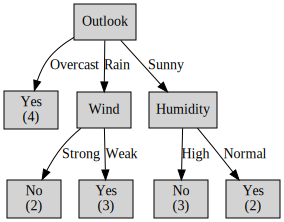

In [ ]:
%%capture --no-display
X = playball.drop(columns=['Play']).to_numpy().tolist()
y = playball.Play.to_numpy().tolist()
feature_names = playball.drop(columns=['Play']).columns

model = Id3Estimator()
model.fit(X, y)

#Meerdere manier om tree te tonen op scherm
#Optie 1 : Print als ASCII
export_text(model.tree_, feature_names=playball.drop(['Play'], axis=1).columns)


#Optie 2 : gebruik GraphViz om model om te zetten naar grafisch object
model_tree = export_graphviz(model.tree_, feature_names=playball.drop(columns=['Play']).columns)
graph = graphviz.Source(model_tree.dot_tree)
graph

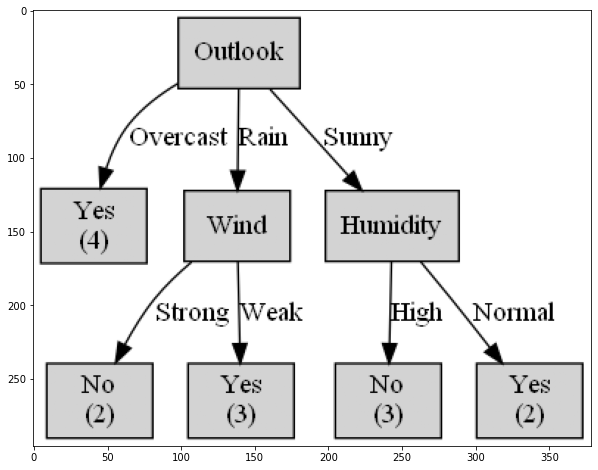

In [ ]:
#  Nog enkele extra mogelijkheden om boomstructuur te maken via dotfiles en png files
import os

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
#Optie 3 : gebruik GraphViz om om te zetten naar aparte .dot file
#install GraphViz from https://graphviz.org/download/#windows
#make sure to add it's bin folder to PATH https://superuser.com/questions/949560/how-do-i-set-system-environment-variables-in-windows-10
#model_tree = export_graphviz(model.tree_, 'tree-playball.dot', feature_names=feature_names)

#Optie 3.1 : install the 'dotPlugin' in Pycharm : https://plugins.jetbrains.com/plugin/10312-dotplugin
#en open het nieuwe bestand in pyCharm

#Optie 3.2 : gebruik graphiviz om het nieuwe bestand te tonen
graphviz.Source.from_file('tree-playball.dot')

#Optie 3.3 : gebruik graphiviz vanaf de commandline om nieuwe bestand naar PNG om te zetten
! dot -Tpng tree-playball.dot -o tree-playball.png

img = plt.imread('tree-playball.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

7. Maak nu een voorspelling? Wordt er gespeeld bij volgende weersomstandigheden?
 * Outlook = Sunny
 * Temperature = Mild
 * Humidity = High
 * Wind = Weak

In [ ]:
Z = np.array([['Sunny', 'Mild', 'High', 'Weak']])
model.predict(Z)
## => NO

c:\users\baekelr\datascience1\datascience\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  return f(**kwargs)


array(['No'], dtype='<U3')